In [1]:
import os

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms,datasets

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shutil
import random
import kagglehub
%matplotlib inline

In [2]:
path = kagglehub.dataset_download("nikolasgegenava/sneakers-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/sneakers-classification


In [3]:
OUTPUT_FOLDER = 'split_data'
SOURSE_FOLDER = '/kaggle/input/sneakers-classification/sneakers-dataset/sneakers-dataset'

In [5]:

# if not os.path.exists(OUTPUT_FOLDER):
#   os.makedirs(OUTPUT_FOLDER)

# for root,dirs,files in os.walk(SOURSE_FOLDER):
#   for file in files:
#     file_path = os.path.join(root,file)
#     shutil.copy(file_path,OUTPUT_FOLDER)

In [6]:
# train_folder_path = 'train'
# test_folder_path = 'test'

# if not os.path.exists(train_folder_path):
#   os.makedirs(train_folder_path)
# if not os.path.exists(test_folder_path):
#   os.makedirs(test_folder_path)

# files = os.listdir('split_data')
# random.shuffle(files)

# train_size = int(len(files) * 0.8)
# train = files[:train_size]
# test = files[train_size:]

# for file in train:
#     shutil.move(os.path.join('split_data', file), os.path.join(train_folder_path, file))
# for file in test:
#     shutil.move(os.path.join('split_data', file), os.path.join(test_folder_path, file))

In [4]:
classes = os.listdir(SOURSE_FOLDER)
classes

['new_balance_992',
 'nike_air_max_1',
 'nike_air_jordan_1_high',
 'nike_air_vapormax_plus',
 'converse_chuck_70_high',
 'nike_air_force_1_high',
 'converse_one_star',
 'converse_chuck_taylor_all-star_low',
 'vans_old_skool',
 'nike_air_max_90',
 'reebok_classic_leather',
 'adidas_samba',
 'new_balance_574',
 'nike_air_jordan_4',
 'nike_air_max_270',
 'nike_air_vapormax_flyknit',
 'yeezy_slide',
 'converse_chuck_70_low',
 'nike_cortez',
 'adidas_nmd_r1',
 'nike_blazer_mid_77',
 'vans_sk8-hi',
 'nike_air_jordan_1_low',
 'reebok_club_c_85',
 'nike_dunk_low',
 'nike_air_force_1_low',
 'nike_air_jordan_11',
 'yeezy_boost_350_v2',
 'adidas_ultraboost',
 'nike_dunk_high',
 'puma_suede_classic',
 'vans_authentic',
 'nike_air_jordan_3',
 'salomon_xt-6',
 'new_balance_990',
 'adidas_forum_high',
 'adidas_gazelle',
 'asics_gel-lyte_iii',
 'nike_air_max_95',
 'adidas_forum_low',
 'adidas_stan_smith',
 'new_balance_550',
 'converse_chuck_taylor_all-star_high',
 'yeezy_700_wave_runner',
 'nike_air_

## Поділення даних на train and test

In [5]:

for name in classes:
  os.makedirs(os.path.join('train',name),exist_ok=True)
  os.makedirs(os.path.join('test',name),exist_ok=True)

  class_path = os.path.join(SOURSE_FOLDER,name)
  images = os.listdir(class_path)
  random.shuffle(images)

  if len(images) < 2:
    continue

  train_images,test_images = train_test_split(images,train_size=0.8,random_state=42)

  for img in train_images:
        src = os.path.join(class_path, img)
        dst = os.path.join('train', name, img)
        shutil.copy(src, dst)

  for img in test_images:
      src = os.path.join(class_path, img)
      dst = os.path.join('test', name, img)
      shutil.copy(src, dst)


In [6]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_dataset = datasets.ImageFolder(root='train',transform=train_transform)
test_dataset = datasets.ImageFolder(root='test',transform=test_transform)

train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=False)

In [42]:
from PIL import Image

img_path, _ = train_dataset.samples[0]
img = Image.open(img_path)
print('Size before to transform',img.size)

Size before to transform (162, 106)


In [43]:
image_tensor, label = train_dataset[0]
print(image_tensor.shape)

torch.Size([3, 224, 224])


### Створювання моделі **CNN**

In [14]:
class CNN(nn.Module):
  def __init__(self, in_channels, num_classes):
    super(CNN,self).__init__()
    self.conv1= nn.Conv2d(in_channels=in_channels,out_channels=8,kernel_size=3,stride=1,padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
    self.conv2 = nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,stride=1,padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
    self.conv3 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1)
    self.dropout = nn.Dropout(0.5)
    # якщо дивимося скільки в нас Conv2d і кожен раз /2
    self.fc1 = nn.Linear(32*28*28,num_classes)

  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = F.relu(self.conv3(x))
    x = self.pool(x)
    # print(x.shape) # Можна додати сюди якщо не знаєш як порахувати перед
    x = x.reshape(x.shape[0],-1)
    x = self.dropout(x)
    x = self.fc1(x)

    return x

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
device

'cuda'

## How to calculate input layers

    nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

output size = | W-K+2P / S| + 1

𝑊
W: розмір вхідного зображення (ширина або висота)

𝐾
K: розмір ядра (kernel_size)

𝑃
P: padding

𝑆
S: stride

    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
Ділить кожне вимірювання навпіл 256/2

    batch_size × 8 × 14 × 14

Перехід до fully connected (FC)

    self.fc1 = nn.Linear(16*7*7, num_classes)

!! Перед лінійним шаром потрібно «розплющити» тензор (flatten):

    x = x.reshape(x.shape[0], -1)



In [27]:
def compute_output_dim(W, K, P, S):
    return (W - K + 2 * P) // S + 1

# приклад
input_size = 100**2
out1 = compute_output_dim(input_size, 3, 1, 1)  # після conv1
out1 = out1 // 2  # після pool1
out2 = compute_output_dim(out1, 3, 1, 1)  # після conv2
out2 = out2 // 2  # після pool2
print("Підсумковий розмір перед FC:", out2, "×", out2)


Підсумковий розмір перед FC: 2500 × 2500


### Алгоритм проєктування **CNN**:

Знаєш розмір входу? Наприклад, 1×28×28.

Вибирай параметри Conv2d. Розраховуй вихід за формулою.

Після кожного Conv2d (можна) додати MaxPool. Зменшує розмір у 2 рази.

Повторюй згортки + pooling скільки потрібно.

Перед FC слоєм — обчисли кількість елементів у тензорі:
Кількість каналів
×
висота
×
ширина
Кількість каналів×висота×ширина

Задай nn.Linear на основі цього розміру.

# The training of model

In [16]:
input_size = 224**2
num_classes = len(classes)
learning_rate = 0.001
batch_size = 32

model = CNN(in_channels=3,num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)

In [11]:
from torchvision import models

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features,len(classes))
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
import time

start = time.time()

EPOCHS = 32
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for epoch in range(EPOCHS):
    model.train()
    trn_corr = 0
    total_loss = 0

    # Train
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)

        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        trn_corr += (predicted == y_train).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_losses.append(total_loss / len(train_loader))
    train_correct.append(trn_corr / len(train_dataset))

    # --- Evaluation ---
    model.eval()
    tst_corr = 0
    tst_loss = 0

    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)

            y_val = model(X_test)
            loss = criterion(y_val, y_test)
            tst_loss += loss.item()

            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum().item()

    test_losses.append(tst_loss / len(test_loader))
    test_correct.append(tst_corr / len(test_dataset))

    print(f'Epoch {epoch+1}: Train Acc: {train_correct[-1]*100:.2f}%, '
          f'Test Acc: {test_correct[-1]*100:.2f}%, '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Test Loss: {test_losses[-1]:.4f}')

end = time.time()
print(f"Training took: {(end - start)/60:.2f} minutes")

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1: Train Acc: 3.69%, Test Acc: 5.90%, Train Loss: 3.8898, Test Loss: 3.7391
Epoch 2: Train Acc: 8.88%, Test Acc: 13.63%, Train Loss: 3.6810, Test Loss: 3.4083
Epoch 3: Train Acc: 14.28%, Test Acc: 21.36%, Train Loss: 3.4356, Test Loss: 3.1294
Epoch 4: Train Acc: 19.65%, Test Acc: 30.65%, Train Loss: 3.2412, Test Loss: 2.8514
Epoch 5: Train Acc: 23.43%, Test Acc: 36.28%, Train Loss: 3.0532, Test Loss: 2.5823
Epoch 6: Train Acc: 28.45%, Test Acc: 41.34%, Train Loss: 2.8205, Test Loss: 2.3439
Epoch 7: Train Acc: 32.33%, Test Acc: 48.12%, Train Loss: 2.6540, Test Loss: 2.0579
Epoch 8: Train Acc: 35.70%, Test Acc: 53.88%, Train Loss: 2.4947, Test Loss: 1.8926
Epoch 9: Train Acc: 39.19%, Test Acc: 56.97%, Train Loss: 2.3584, Test Loss: 1.7493
Epoch 10: Train Acc: 43.43%, Test Acc: 60.02%, Train Loss: 2.2199, Test Loss: 1.6100
Epoch 11: Train Acc: 45.51%, Test Acc: 64.39%, Train Loss: 2.1028, Test Loss: 1.4949
Epoch 12: Train Acc: 48.17%, Test Acc: 66.56%, Train Loss: 1.9973, Test Loss:

In [51]:
correct = 0
total = 0
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Загальна точність моделі: {accuracy:.2f}%")


Загальна точність моделі: 91.29%


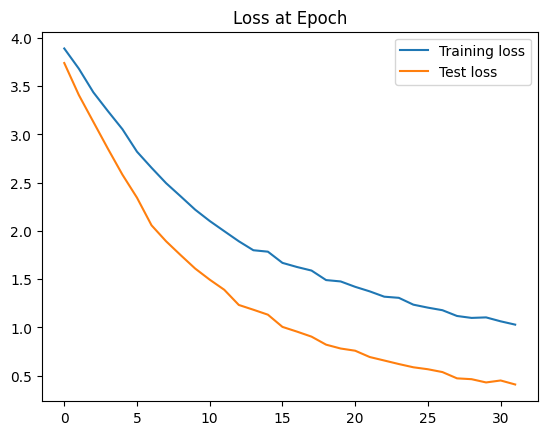

In [18]:
plt.plot(train_losses,label="Training loss")
plt.plot(test_losses, label="Test loss")
plt.title("Loss at Epoch")
plt.legend()


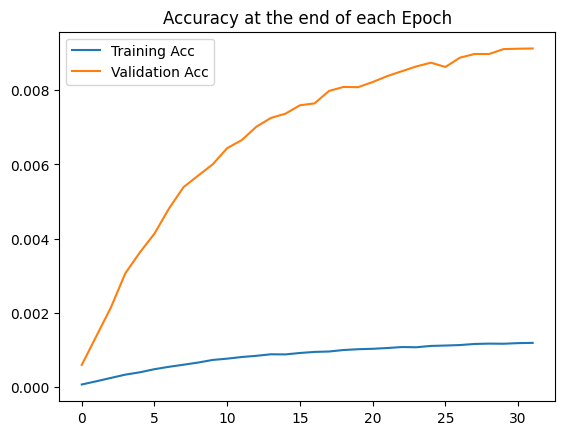

In [19]:
plt.plot([t/600 for t in train_correct],label="Training Acc")
plt.plot([t/100 for t in test_correct],label="Validation Acc")
plt.title("Accuracy at the end of each Epoch")
plt.legend()

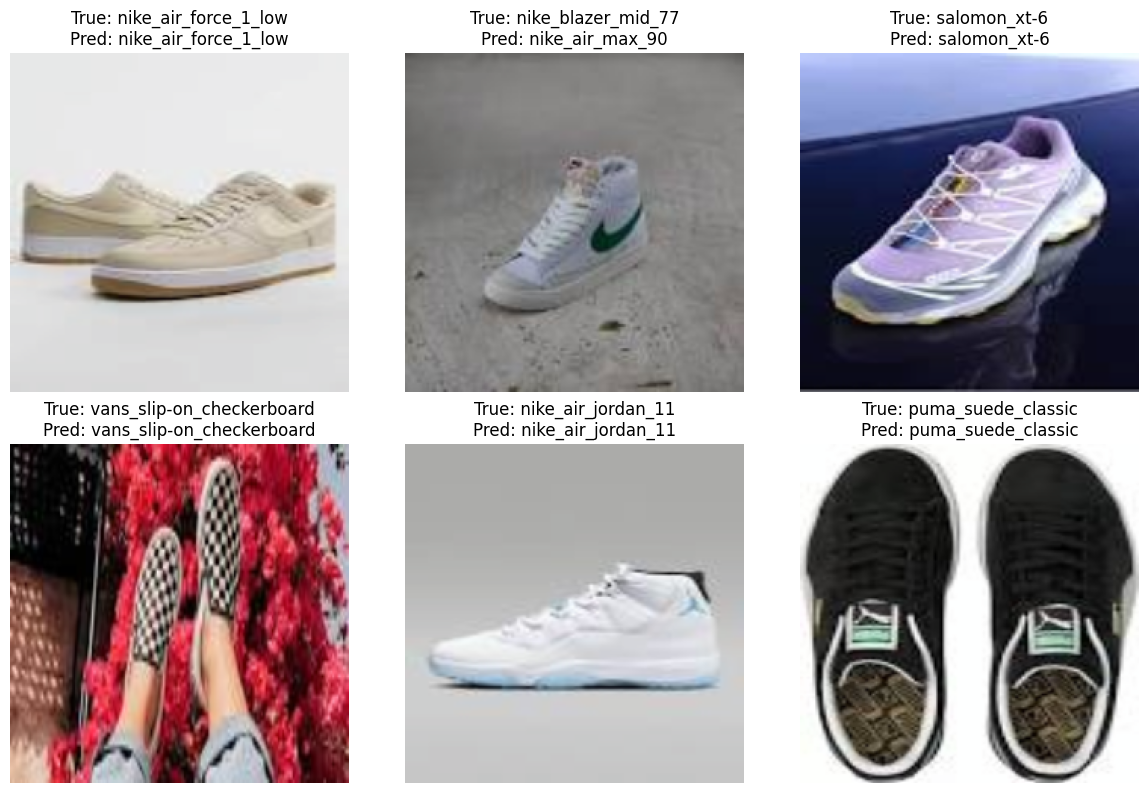

In [48]:
from PIL import Image

root_dir = "test"  # або "train", якщо хочеш звідти
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class_names = sorted(os.listdir(root_dir))

num_random_classes = 6
random_classes = random.sample(class_names, num_random_classes)
model.eval()

def imshow_input(tensor, title=None):
    img = tensor.cpu().squeeze().permute(1, 2, 0).numpy()
    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img = img.clip(0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis("off")

# === Основна логіка ===
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(random_classes[:6]):
    class_path = os.path.join(root_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png'))]
    chosen_image = random.choice(image_files)
    image_path = os.path.join(class_path, chosen_image)

    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        _, pred = torch.max(output, 1)

    plt.subplot(2, 3, i+1)
    imshow_input(img_tensor[0], title=f"True: {class_name}\nPred: {class_names[pred.item()]}")

plt.tight_layout()
plt.show()

